In [38]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import scipy as sc

## Importing the data

In [39]:
#training data
all_data=pd.read_csv("C:\\Users\\HP\\Documents\\GitHub\\Wind_Power\\Data\\Data_for_this_paper\\Table_Training_Complete.csv",encoding='utf-8')

In [40]:
def data(beg,end):
    l=[col[0]]
    l.extend(col[beg:end])
    return(all_data[l])

In [41]:
test=pd.read_csv("C:\\Users\\HP\\Desktop\\Classeur1.csv",encoding='utf-8',header=None)

In [42]:
col=all_data.columns.to_list()

In [43]:
time=data(1,146)

In [44]:
forecast=data(146,291)

In [45]:
adme=data(580,725)

In [46]:
forecast=forecast.iloc[:127]
adme=adme.iloc[:127]

### Constants

In [47]:
theta1=0.1
theta2=0.2
dt=0.0069
max_change=1.01
max_iter2=100
max_iter1=50
gamma=0.2

## LSM

In [48]:
def constant(error,dt):
    a=error.drop(['Date'],axis=1)
    M,N=a.shape
    num=0
    den=0
    for i in range(M):
        for j in range(N-1):
            if (a.iloc[i,j+1]!=-1 and a.iloc[i,j]!=-1) :
                num+=a.iloc[i,j]*(a.iloc[i,j]-a.iloc[i,j+1])
                den+=(a.iloc[i,j])**2
    return(num/(den*dt))

#We supposed that theta_t=c a constant determinized by minimization
def constant_c(error,dt):
    a=error.drop(['Date'],axis=1)
    M,N=a.shape
    num=0
    den=0
    for i in range(M):
        #e=a.iloc[i].shift(-1)
        e2=pd.Series([j for j in range(len(a.iloc[i])-1) if a.iloc[i][j+1]!=-1])
        e1=e2.shift(-1)
        x=(e2*(e2-e1)).to_list()
        if len(x)!=0:
            x=pd.Series(x)
            x=x.drop(x.index[len(x)-1])
        num+=sum(x)
        den+=sum(e2**2)
    return(num/(den*dt))

In [50]:
#k=theta_0*alpha/eps when the forecast pe=eps or 1-eps for eps<<1
def estimation_k(adme,dt):
    est=0
    a=adme.drop(['Date'],axis=1)
    M,N=a.shape
    for i in range(M):
        num=0
        den=0
        x=(a.iloc[i].shift(-1)-a.iloc[i])**2
        x=x.drop(x.index[len(x)-1])
        num+=sum(x)
        den+=sum(a.iloc[i]*(1-a.iloc[i]))
        est+=num/den
    return(est/(2*dt*M))

In [51]:
def error(adme,col_err,forecast_eps):
    error_eps=adme.drop(['Date'],axis=1)-forecast_eps.drop(['Date'],axis=1).values
    error_eps.insert(0,'Date',adme['Date'])
    error_eps.columns=col_err
    error_eps=error_eps.fillna(-1)
    return(error_eps)

## Forecast P epsilon

In [52]:
def I(gamma,x,forecast):
    forecast_gamma=forecast.copy()
    m=forecast_gamma[x]>=gamma
    v=forecast_gamma[x]<=1-gamma
    forecast_gamma=forecast_gamma.where(m & v)
    #forecast_gamma=forecast_gamma.where(m | v,-1)
    forecast_gamma['Date']=forecast['Date']
    return(forecast_gamma)

In [53]:
def pe(eps,x,forecast):
    forecast_eps=forecast.copy()
    m=forecast[x]<eps
    v=forecast[x]>=1-eps
    forecast_eps=forecast_eps.where(~m,eps)
    forecast_eps=forecast_eps.where(~v,1-eps)
    forecast_eps['Date']=forecast['Date']
    return(forecast_eps)

In [54]:
def J(eps,x,forecast_eps):
    m=forecast_eps[x]==eps
    v=forecast_eps[x]==1-eps
    forecast_j=forecast_eps.where(m | v)
    #forecast_eps=forecast_eps.where(v)
    forecast_j['Date']=forecast_eps['Date']
    return(forecast_j)

col_err=['Date']
l=['error_'+str(i) for i in range(1,146)]
col_err.extend(l)
x=forecast.columns.to_list()
del x[0]
forecast_eps=pe(0.0168,x,forecast)
c=J(0.0168,x,forecast_eps)
err_eps=error(adme,col_err,c)
constant(err_eps,dt)

In [55]:
def epsilon(gamma,dt,adme,forecast,max_iter1,max_iter2,max_change):
   #os.chdir(directory)
    x=forecast.columns.to_list()
    del x[0]
    col_err=['Date']
    l=['error_'+str(i) for i in range(1,146)]
    col_err.extend(l)
    k=estimation_k(adme,dt)
    forecast_gamma=I(gamma,x,forecast)
    err_gamma=error(adme,col_err,forecast_gamma)
    c0=constant(err_gamma,dt)
    print('c0: ',c0)
    for i in range(max_iter1):
        eps_vect=[]
        #eps0=np.random.uniform(0.01,0.1)
        eps0=0.01+np.random.random_sample()*0.09
        eps_vect.append(eps0)
        j=1
        print(i)
        while j<max_iter2:
            eps=eps0
            print('eps:' ,eps)
            forecast_eps=pe(eps,x,forecast)
            forecast_only_eps=J(eps,x,forecast_eps)
            err_eps=error(adme,col_err,forecast_only_eps)
            c=constant(err_eps,dt)
            print('c: ',c)
            if c > c0:
                print('oui')
                eps0 = k/c
                if eps0 > eps*max_change:
                    eps0 = eps*max_change
                elif eps0 < eps/max_change:
                    eps0 = eps/max_change
                eps_vect.append(eps0)
                j+=1
            else:
                eps0= eps0 * 0.999
        fig=plt.plot(eps_vect)
    plt.title("Epsilon over the iterations")
    plt.xlabel('Iteration')
    plt.ylabel('Epsilon')
    plt.savefig('epsilon.eps',format='eps',dpi=1000)
    plt.show()
    return(eps)

In [56]:
#the minimum reached
eps=0.018

In [60]:
g

array([0.01 , 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017, 0.018,
       0.019, 0.02 , 0.021, 0.022, 0.023, 0.024, 0.025, 0.026, 0.027,
       0.028, 0.029, 0.03 , 0.031, 0.032, 0.033, 0.034, 0.035, 0.036,
       0.037, 0.038, 0.039, 0.04 , 0.041, 0.042, 0.043, 0.044, 0.045,
       0.046, 0.047, 0.048, 0.049, 0.05 , 0.051, 0.052, 0.053, 0.054,
       0.055, 0.056, 0.057, 0.058, 0.059, 0.06 , 0.061, 0.062, 0.063,
       0.064, 0.065, 0.066, 0.067, 0.068, 0.069, 0.07 , 0.071, 0.072,
       0.073, 0.074, 0.075, 0.076, 0.077, 0.078, 0.079, 0.08 , 0.081,
       0.082, 0.083, 0.084, 0.085, 0.086, 0.087, 0.088, 0.089, 0.09 ,
       0.091, 0.092, 0.093, 0.094, 0.095, 0.096, 0.097, 0.098, 0.099,
       0.1  , 0.101, 0.102, 0.103, 0.104, 0.105, 0.106, 0.107, 0.108,
       0.109, 0.11 , 0.111, 0.112, 0.113, 0.114, 0.115, 0.116, 0.117,
       0.118, 0.119, 0.12 , 0.121, 0.122, 0.123, 0.124, 0.125, 0.126,
       0.127, 0.128, 0.129, 0.13 , 0.131, 0.132, 0.133, 0.134, 0.135,
       0.136, 0.137,

In [62]:
gamma=0.49
forecast_gamma=I(gamma,x,forecast)
err_gamma=error(adme,col_err,forecast_gamma)
constant(err_gamma,dt)

0.6492053214288799

0
[1.2374382669840187]
1
[1.2374382669840187, 1.2374209344820404]
2
[1.2374382669840187, 1.2374209344820404, 1.2374168538029477]
3
[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453]
4
[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067]
5
[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693]
6
[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283]
7
[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657]
8
[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435]
9
[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.23741425735145

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305]
30
[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255]
42
[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.23737

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

[1.2374382669840187, 1.2374209344820404, 1.2374168538029477, 1.237414257351453, 1.2373935048333067, 1.2373954038415693, 1.2373775896978283, 1.2373804414937657, 1.2373765788300435, 1.2373987816423042, 1.2374545679669466, 1.2375253711815684, 1.2384476883795346, 1.2408586889279027, 1.2401682502286655, 1.2433648711692662, 1.2432415587025851, 1.2432305559989336, 1.245261693106173, 1.2452055035202223, 1.2447078915816, 1.2444013208032114, 1.2428736182178113, 1.2428825869759808, 1.2427546726459735, 1.2343430276874696, 1.2328915310692805, 1.2317197169663905, 1.2316014861058913, 1.2383635189513305, 1.2386160249238407, 1.239658704900906, 1.2388352423800044, 1.2393143214358382, 1.2378837632785458, 1.237215422061034, 1.24289892530608, 1.242090419532239, 1.244349594583293, 1.2446102787543134, 1.2469869539897793, 1.2469421031674255, 1.2484468037301168, 1.2509985709425546, 1.2478797733419247, 1.2492580064252203, 1.249775564969923, 1.2523250129585137, 1.2411672263150988, 1.2408123016320862, 1.241214209

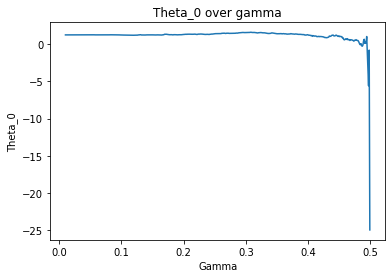

In [64]:
c0=[]
g=np.arange(0.01,0.4999,0.001)
x=forecast.columns.to_list()
del x[0]
col_err=['Date']
l=['error_'+str(i) for i in range(1,146)]
col_err.extend(l)
for i in range(len(g)):
    print(i)
    forecast_gamma=I(g[i],x,forecast)
    err_gamma=error(adme,col_err,forecast_gamma)
    c0.append(constant(err_gamma,dt))
    print(c0)
fig=plt.plot(g,c0)
plt.title("Theta_0 over gamma")
plt.xlabel('Gamma')
plt.ylabel('Theta_0')
plt.savefig('theta0.eps',format='eps',dpi=1000)
plt.show()

In [70]:
c1=c0[:472]

In [71]:
c1

[1.2374382669840187,
 1.2374209344820404,
 1.2374168538029477,
 1.237414257351453,
 1.2373935048333067,
 1.2373954038415693,
 1.2373775896978283,
 1.2373804414937657,
 1.2373765788300435,
 1.2373987816423042,
 1.2374545679669466,
 1.2375253711815684,
 1.2384476883795346,
 1.2408586889279027,
 1.2401682502286655,
 1.2433648711692662,
 1.2432415587025851,
 1.2432305559989336,
 1.245261693106173,
 1.2452055035202223,
 1.2447078915816,
 1.2444013208032114,
 1.2428736182178113,
 1.2428825869759808,
 1.2427546726459735,
 1.2343430276874696,
 1.2328915310692805,
 1.2317197169663905,
 1.2316014861058913,
 1.2383635189513305,
 1.2386160249238407,
 1.239658704900906,
 1.2388352423800044,
 1.2393143214358382,
 1.2378837632785458,
 1.237215422061034,
 1.24289892530608,
 1.242090419532239,
 1.244349594583293,
 1.2446102787543134,
 1.2469869539897793,
 1.2469421031674255,
 1.2484468037301168,
 1.2509985709425546,
 1.2478797733419247,
 1.2492580064252203,
 1.249775564969923,
 1.2523250129585137,
 1.2

In [73]:
g1=g[:472]

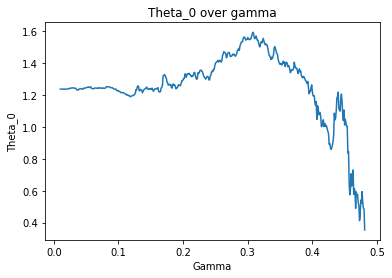

In [74]:
fig=plt.plot(g1,c1)
plt.title("Theta_0 over gamma")
plt.xlabel('Gamma')
plt.ylabel('Theta_0')
plt.savefig('theta0.eps',format='eps',dpi=1000)
plt.show()

In [77]:
np.mean(c1)

1.2541508069461607

In [79]:
0.094/1.25

0.0752